In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
import os 
import mglearn
import re
import datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:

## prepare_weather_data 

WEATHER_DIR = './weather'
all_files = os.listdir(WEATHER_DIR)

data = pd.DataFrame()

for weather_file in all_files :

    if str(weather_file[-4:]) == '.csv' :

        file_path = os.path.join(WEATHER_DIR,str(weather_file))
        wdata = pd.read_csv(str(file_path),skiprows=range(16))
        data = data.append(wdata)



In [3]:
## remove feature with Nan and create timestamps for each sample

c = [i for i in data.columns if data.loc[:,i].count() != 0  and i!= 'Hmdx']
ndata = data[c]

def to_datetime(row) : 
    REGEX = '^([0-9]{4})-([0-9]{2})-([0-9]{2}) ([0-9]{2}).*$'
    m = re.match(REGEX,row)
    
    year = int(m.group(1))
    month = int(m.group(2))
    day = int(m.group(3))
    time =  int(m.group(4))
    
    return datetime.datetime(year,month,day,time,0,0)

ndata['Date/Time'] = ndata['Date/Time'].apply(to_datetime)
ndata['timestamp'] = ndata['Date/Time'].values.astype(np.int64)

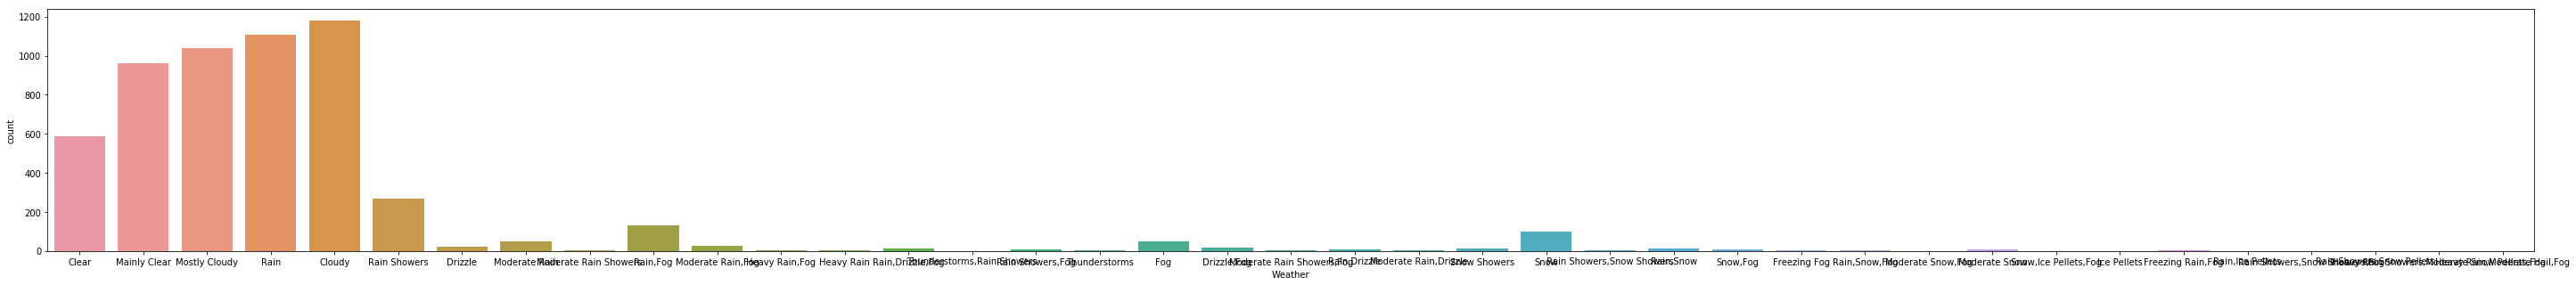

In [4]:
## shows unique weather category descritipion


weather_desc = pd.DataFrame(np.array(ndata['Weather'].unique()),columns=['WEATHER_DESC.'])
weather_desc
fig,ax = plt.subplots(figsize=(50,5))
x = sns.countplot(ax=ax,data=data,x=data['Weather'])
plt.savefig('plots/weather.jpg')

In [5]:
## FEATURE COMPARISON

def assign_colors(val) : 
    
    
    if val == 'Clear' : 
        color = 'pink'
    elif val == 'Mainly Clear' : 
        color = 'Orange'
    elif val == 'Mostly Cloudy' : 
        color = 'coral'
    elif val == 'Rain' : 
        color = 'Blue'
    elif val == 'Cloudy' : 
        color = 'dimgrey'
    elif val == 'Rain Showers' : 
        color = 'green'
    else : 
        color = 'gold'
    return color

ndata['color'] = ndata['Weather'].apply(assign_colors)
features = ndata[['Data Quality','Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)','Visibility (km)','Stn Press (kPa)']]


In [6]:
## FEATURE-ENGINEERING : CREATING 8 NEW FIELDS TO IDENTIFY DESCRIPTIONS SIMENTANEOUSLY
## Thunderstorms,drizzle are identified as rain category



def is_rain(val) : 
    REGEX1 = '^.*Rain.*$'
    REGEX2 = '^.*Drizzle.*$'
    REGEX3 = '^.*Thunderstorms.*$'
    if re.match(REGEX1,str(val)) is not None or re.match(REGEX2,str(val)) is not None or re.match(REGEX3,str(val)) is not None   : 
       
        return 1 
    else : 
        return 0
    
def is_clear(val) : 
    if re.match('^.*Clear.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0

def is_snow(val) :
    if re.match('^.*Snow.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0

def is_fog(val) : 
    if re.match('^.*Fog.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0
    
def is_cloudy(val) : 
    if re.match('^.*Cloudy.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0
    
    
def is_pellets(val) : 
    if re.match('^.*Pellets.*$',str(val) ) is not None : 
        return 1 
    else : 
        return 0

def new_weather_label(val) : 
    
    
    if val.is_pellets == 1 : 
        return 'Pellets'
    elif val.is_clear == 1 : 
        return 'Clear'
    elif val.is_rain == 1 : 
        return 'Rain'
    elif val.is_cloudy == 1 : 
        return 'Cloudy'
    elif val.is_fog == 1 : 
        return 'Fog'
    else : 
        return 'Unknown'
    


ndata['is_clear'] = ndata['Weather'].apply(is_clear)
ndata['is_snow'] = ndata['Weather'].apply(is_snow)
ndata['is_fog'] = ndata['Weather'].apply(is_fog)
ndata['is_cloudy'] = ndata['Weather'].apply(is_cloudy)
ndata['is_pellets'] = ndata['Weather'].apply(is_pellets)

ndata['is_rain'] = ndata['Weather'].apply(is_rain)


ldata = ndata[ndata['Weather'].isnull() == 0]
udata = ndata[ndata['Weather'].isnull() == 1]

ldata['new_weather'] = ldata.apply(new_weather_label,axis=1)
ldata['new_weather'].value_counts()


Cloudy     2220
Rain       1699
Clear      1548
Unknown     119
Fog          62
Pellets       5
Name: new_weather, dtype: int64

In [7]:
## image data 

def image_datetime(row) :
    year = int(row['year'])
    month = int(row['month'])
    day = int(row['day'])
    hour = int(row['hour'])
 
    return datetime.datetime(year,month,day,hour,0,0)


IMAGE_DIR = 'image_data/katkam-scaled'

contents = os.listdir(IMAGE_DIR)
filenames = pd.DataFrame(contents,columns=['title'])


filenames['year'] = filenames['title'].str.extract('katkam-([0-9]{4}).*\.jpg')
filenames['month'] = filenames['title'].str.extract('katkam-[0-9]{4}([0-9]{2}).*\.jpg')
filenames['day'] = filenames['title'].str.extract('katkam-[0-9]{4}[0-9]{2}([0-9]{2}).*\.jpg')
filenames['hour'] = filenames['title'].str.extract('katkam-[0-9]{4}[0-9]{2}[0-9]{2}([0-9]{2}).*\.jpg')

filenames['timestamp'] = filenames.apply(image_datetime,axis=1)
filenames['title'].count()

6991

In [8]:
## compiling sun_present and average color data

sun_present_file = 'image_data/SUN_PRESENT.csv'
sun_present = pd.read_csv(sun_present_file,header=None)
sun_present.columns =['image_index','sun_present']

average_color_file = 'image_data/KATKAM_labeled_colors.csv'
average_color = pd.read_csv(average_color_file)
average_color.columns=['file_index','region_id','r','g','b','Label']

sky_color = average_color[average_color['region_id']==1]
sky_color = sky_color[['file_index','r','g','b','Label']]
sky_color = sky_color.reset_index()
sky_color.drop(['index'],axis=1)

filenames['sun_present'] = sun_present['sun_present']
filenames['sky_color_r'] = sky_color['r']
filenames['sky_color_g'] = sky_color['g']
filenames['sky_color_b'] = sky_color['b']
filenames['color_label'] = sky_color['Label']

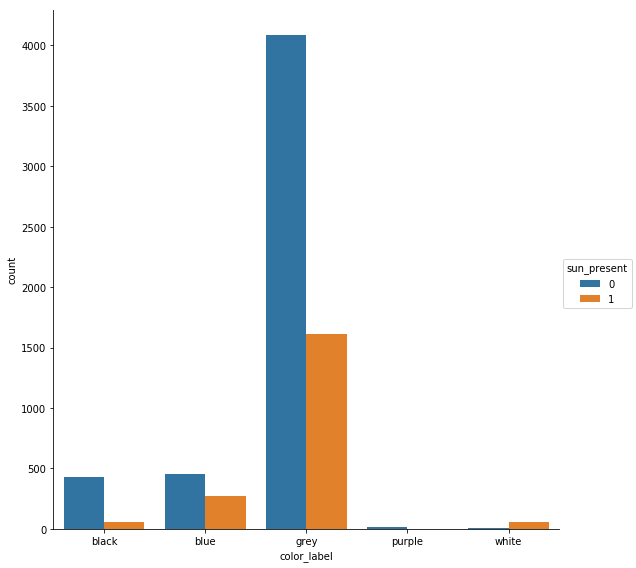

In [9]:
## VISUALIZATIONS FOR THE COLOR <do this >
filenames['color_label'].value_counts()

color_data = filenames[['color_label','sun_present']]
color_data_sun = color_data[color_data['sun_present']==1]
color_data_not_sun = color_data[color_data['sun_present']!=1]

#color_data_sun['color_label'].value_counts().tolist()
#color_data_not_sun['color_label'].value_counts().tolist()
#color_data_sun['color_label'].unique().tolist()

color_agg = color_data.groupby(['color_label','sun_present']).size().to_frame().reset_index()
color_agg.columns=['color_label','sun_present','count']

sns.factorplot(x='color_label',y='count',hue='sun_present',data=color_agg,kind='bar',size=8)

## As we can see, the gray is the highest color when sun was not present. Because the distribution is
## very concentrated in few results, it can affect the training dataset and later predictions.

In [10]:
widata = ldata.merge(filenames,on='timestamp')
widata.columns

Index(['Date/Time', 'Year', 'Month', 'Day', 'Time', 'Data Quality',
       'Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)', 'Wind Dir (10s deg)',
       'Wind Spd (km/h)', 'Visibility (km)', 'Stn Press (kPa)', 'Wind Chill',
       'Weather', 'timestamp', 'color', 'is_clear', 'is_snow', 'is_fog',
       'is_cloudy', 'is_pellets', 'is_rain', 'new_weather', 'title', 'year',
       'month', 'day', 'hour', 'sun_present', 'sky_color_r', 'sky_color_g',
       'sky_color_b', 'color_label'],
      dtype='object')

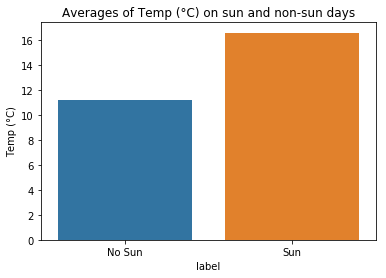

In [11]:
## lets look at average temperature when sun_present vs not sun_present

sun_and_temp = widata[['Temp (°C)','sun_present']]
sun_temp_avg = sun_and_temp.groupby('sun_present').agg(np.mean)
sun_temp_avg = sun_temp_avg.reset_index()
sun_temp_avg['label'] = ['No Sun','Sun'] 

#sns.countplot(x='sun_present',data=sun_and_temp)
sun_temp_avg = sun_temp_avg[['label','Temp (°C)']]
sns.barplot(x='label',y='Temp (°C)',data=sun_temp_avg).set_title('Averages of Temp (°C) on sun and non-sun days')

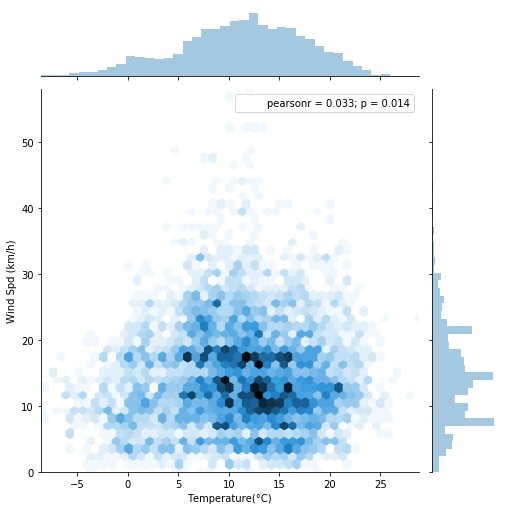

In [12]:
## RELATIONSHIP BETWEEN TEMPERATURE AND WIND DIRECTION

l = ldata[['Temp (°C)','Wind Spd (km/h)']]


ax = sns.jointplot(x=l['Temp (°C)'].values,y=l['Wind Spd (km/h)'].values,kind='hex',size=7)
ax.set_axis_labels('Temperature(°C)','Wind Spd (km/h)')


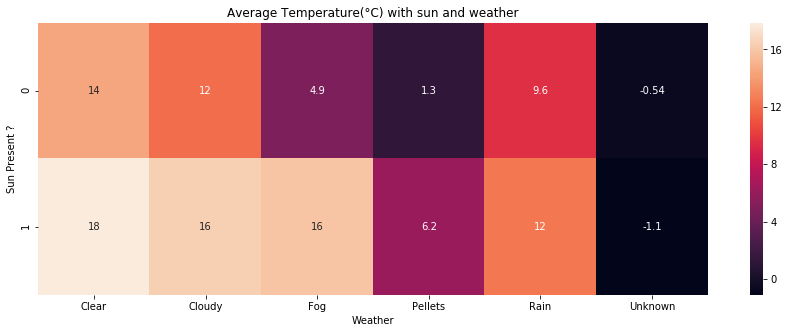

In [13]:
## HEATMAP OF TEMPERTURE, WEATHER AND SUN_PRESENT

ll = widata[['new_weather','sun_present','Temp (°C)']]

ll_pivot = ll.pivot_table(index='sun_present',columns='new_weather',values='Temp (°C)',aggfunc='mean')

hfig,hax = plt.subplots(figsize=(15,5))
sns.heatmap(ll_pivot,annot=True,ax=hax).set_title('Average Temperature(°C) with sun and weather')
plt.xlabel('Weather')
plt.ylabel('Sun Present ?')


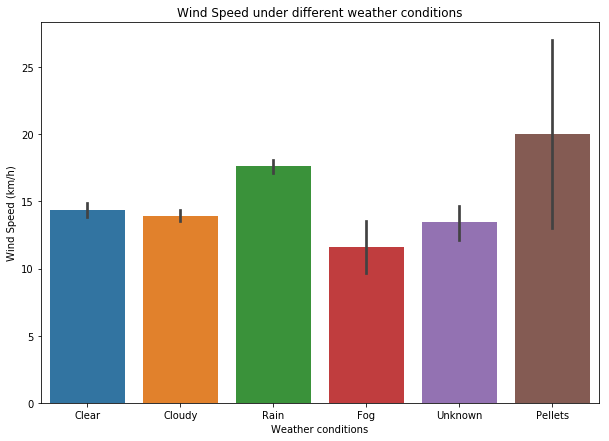

In [14]:
## wind speed and weather conditions

fig,ax = plt.subplots(figsize=(10,7))
sns.barplot(ax=ax,x='new_weather',y='Wind Spd (km/h)',data=widata)
ax.set_xlabel('Weather conditions')
ax.set_ylabel('Wind Speed (km/h)')
ax.set_title('Wind Speed under different weather conditions')

In [15]:
## CRIME DATA

filename = 'crime_csv_all_years.csv'
cdata = pd.read_csv(filename)

years = ['2016','2017']

def year_specific(val) : 
    val = str(val)
    if val in years : 
        return val
    else : 
        return np.nan

to_string = lambda x:str(x)

def crime_datetime(row) : 
    year = int(row['YEAR'])
    month = int(row['MONTH'])
    day = int(row['DAY'])
    hour = int(row['HOUR'])
    return datetime.datetime(year,month,day,hour,0,0)


## only data from 2016 and 2015
cdata['YEAR'] = cdata['YEAR'].apply(to_string)
cdata['YEAR'] = cdata['YEAR'].apply(year_specific)
cdata = cdata.dropna(axis=0,how='any')

## Adding the timestamp
cdata['date/time'] = cdata.apply(crime_datetime,axis=1)
cdata['timestamp'] = cdata['date/time'].values.astype(np.int64)


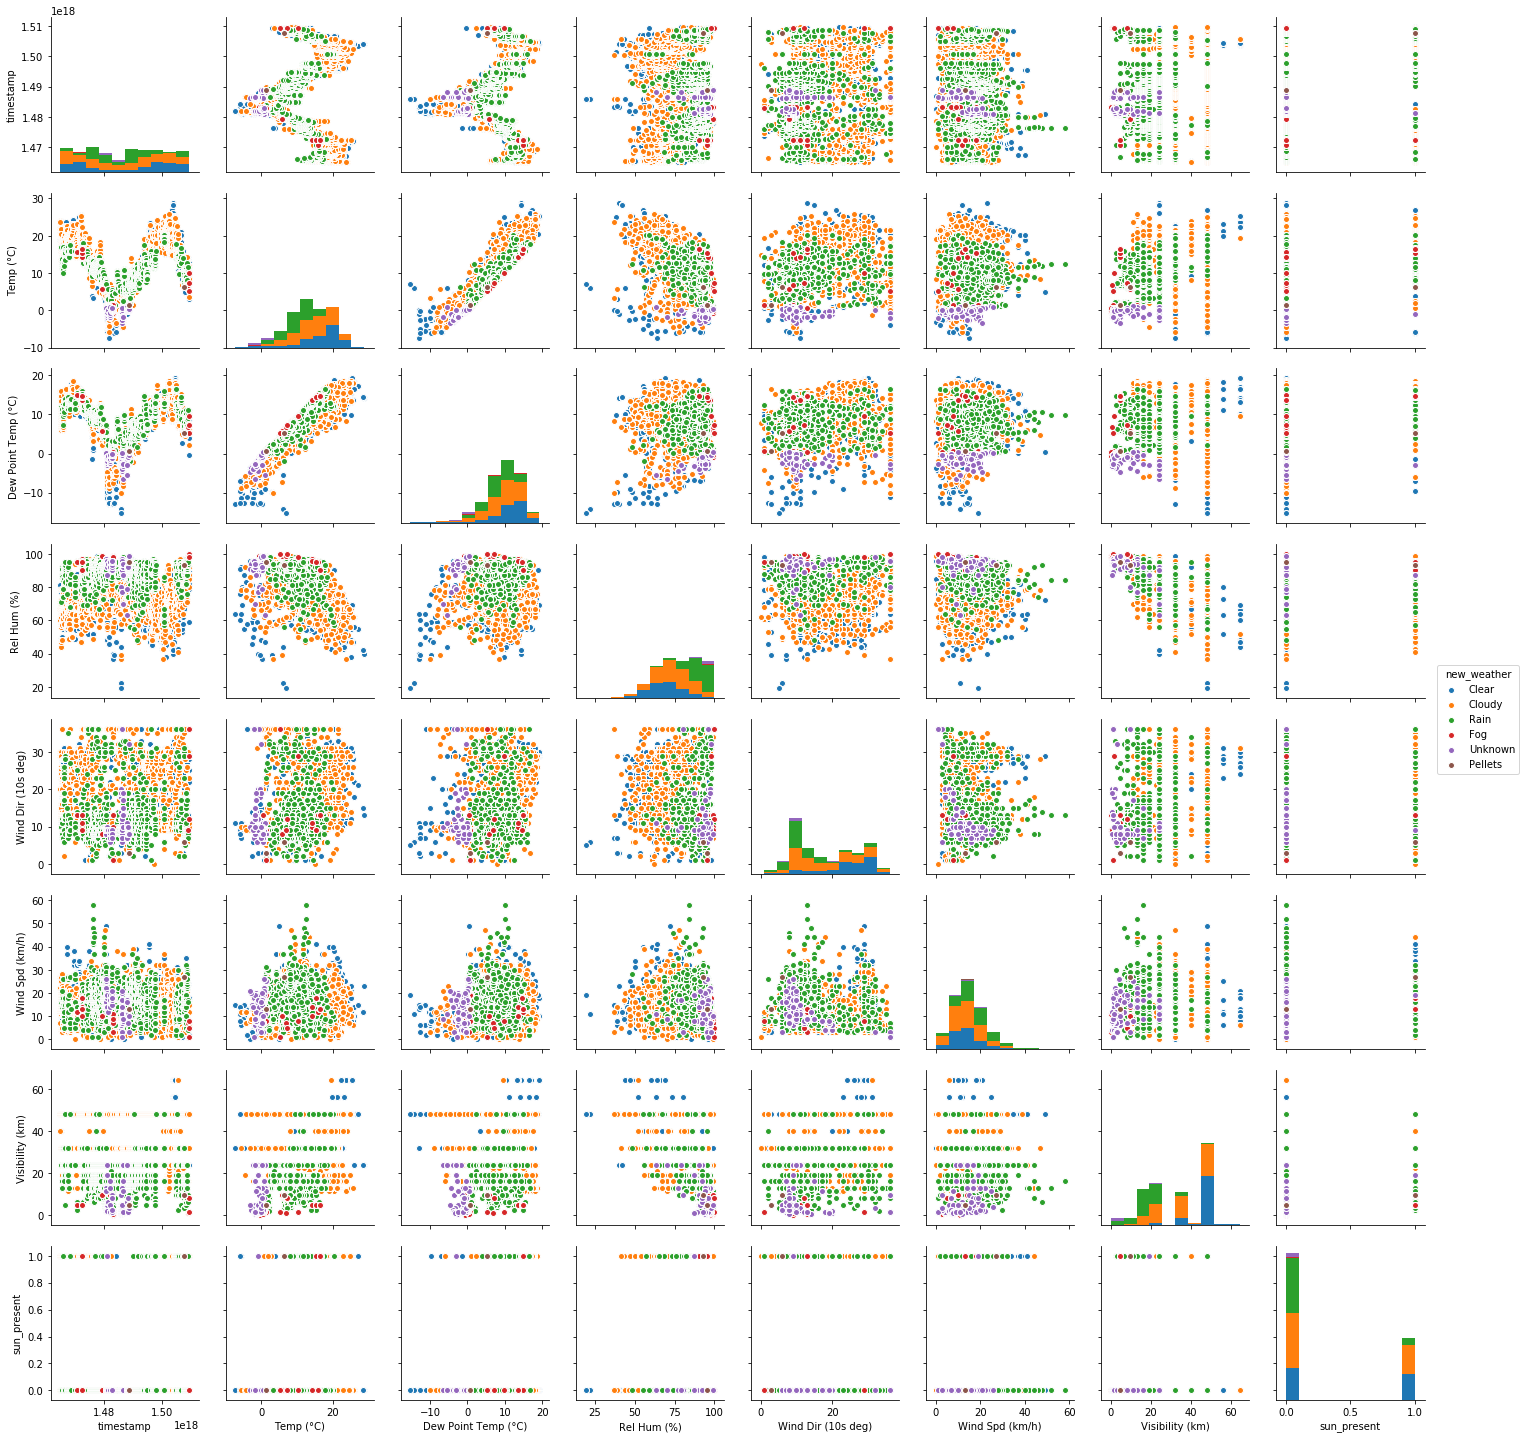

In [16]:
## NOW ADDING CRIME DATA TO THE WEATHER + IMAGE DATASET AND SEE ANY CRUCIAL INFORMATION WE GET OR NOT 
## SCRAP UNRELEVANT DATA

joined_data = widata.merge(cdata,on='timestamp')
joined_features = ['Date/Time','timestamp','Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)','Visibility (km)','TYPE','color_label','sun_present','new_weather']

joined_data = joined_data[joined_features]

## SCRAP UNRELEVANT DATA : Windchill is not very useful, it has lot of missing data with NAN values 
## now the problem is that on a same hour, there are multiple crime types

sns.pairplot(joined_data,hue='new_weather',markers='o')


In [219]:
## DETERMINING TRAINING AND TESTING DATA 

## FEATURE ENGINEERING

joined_data = joined_data.dropna(axis=0,how='any')

labeled_data_X = joined_data.iloc[:,2:9]
labeled_data_X = pd.get_dummies(labeled_data_X)


labeled_data_y = joined_data.iloc[:,11].values



#X_train, X_test, y_train, y_test = train_test_split(labeled_data_X,labeled_data_y)

In [ ]:
## PREPROCESSING  



In [234]:
## MODEL EVALUATION WITHOUT ANY SCALING OR TRANSFORMATIONS (other than done manually above)
## first evaluating minimum manual set parameters 

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import cross_val_score,KFold
import graphviz
from sklearn.pipeline import make_pipeline


bayes_model = make_pipeline(GaussianNB())
bayes_model.__name__ = 'Naive Bayes'
k = 6
knn_model = make_pipeline(KNeighborsClassifier(n_neighbors=k))
knn_model.__name__ = 'KNeighbors'

svm_model = make_pipeline(SVC(kernel='linear',decision_function_shape='ovr'))
svm_model.__name__ = 'SVM'

tree_model = DecisionTreeClassifier(random_state=0)
tree_model.__name__ = 'Decision Tree'
MODEL = [bayes_model,knn_model,svm_model,tree_model]




In [163]:
## INITIAL SCORE WITHOUT MUCH PREPROCESSING

for m in MODEL : 

    m.fit(X_train,y_train)
    print('{} : {}'.format(m.__name__,m.score(X_test,y_test)))
    

Naive Bayes : 0.6018005540166205
KNeighbors : 0.8580332409972299
SVM : 0.6845567867036011
Decision Tree : 0.967797783933518


In [206]:
## WITH CROSS VALIDATION with cv=(2..10)
print('CROSS-VALIDATION')


for j in range(2,10) : 
    print("--- CV = {}-------------------------------------",format(j))
    for m in MODEL : 
        score = cross_val_score(KNeighborsClassifier(n_neighbors=k),labeled_data_X.values,labeled_data_y,cv=j)
        print('{} : {}'.format(m.__name__,score))


(11552,)

In [236]:
## WITH CROSS VALIDATION with cv=KFOLD

kfold = KFold(n_splits=5)
for m in MODEL : 
    score = cross_val_score(KNeighborsClassifier(n_neighbors=k),labeled_data_X.values,labeled_data_y,cv=kfold)
    print('{} : {}'.format(m.__name__,score))

Naive Bayes : [ 0.580701    0.65469494  0.64632035  0.60562771  0.6034632 ]
KNeighbors : [ 0.580701    0.65469494  0.64632035  0.60562771  0.6034632 ]
SVM : [ 0.580701    0.65469494  0.64632035  0.60562771  0.6034632 ]
Decision Tree : [ 0.580701    0.65469494  0.64632035  0.60562771  0.6034632 ]
